In [287]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import scipy.stats as sts

In [185]:
def read_reference_energies():
    folders = glob.glob('naphtalene/validation-molpro/*/')
    res = []
    for folder in folders:
        this = {}
        
        basename = folder.split('/')[-2]
        this['label'] = basename.split('-')[-1]
        this['nbn'] = int(basename.split('-')[1])
        
        try:
            with open(folder+ 'direct.out') as fh:
                lines = fh.readlines()
            this['energy'] = float(lines[-6].strip().split()[-1])
            this['nn'] = float([_ for _ in lines if 'Nuclear energy' in _][0].strip().split()[-1])
        except:
            with open(folder+ 'run.log') as fh:
                lines = fh.readlines()
            this['energy'] = float(lines[-7].strip().split()[-1])
            this['nn'] = float([_ for _ in lines if 'Nuclear repulsion energy' in _][0].strip().split()[-1])
        
        res.append(this)
    return pd.DataFrame(res)
df = read_reference_energies()

In [3]:
def read_report(fn):
    with open(fn) as fh:
        lines = fh.readlines()
    
    order = []
    groups = []
    count = 0
    for line in lines:
        if "Found:" in line:
            label = ''.join(line.split('[')[1].split(']')[0].replace(' ', '').split(','))
            label = label.replace('5', 'B').replace('6', 'C').replace('7', 'N')
            order.append(label)
            count += 1
        
        if "Group energy" in line:
            groups.append(count)
            count = 0
    return order, groups[1:]
#read_report('napthalene-molpro.report')

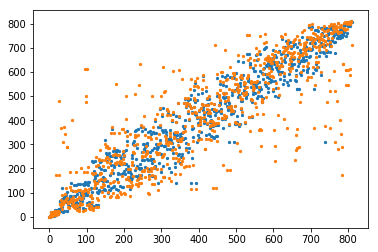

In [515]:
def visualise_report(fn, df):
    report, groups = read_report(fn)
    df = df.sort_values('energy')
    actual = [report.index(_.replace('5', 'B').replace('6', 'C').replace('7', 'N')) for _ in df.label.values]
    
    #bars = np.cumsum(groups)
    #for bar in bars:
    #    plt.axhline(bar, 0.99)
    plt.scatter(range(len(actual)), actual, s=5)
    
#visualise_report('napthalene-molpro-4.5.report', df)
visualise_report('scanning/2.2-CM', df.query("nbn == 4"))
visualise_report('scanning/0.2-ESP', df.query("nbn == 4"))
#visualise_report('napthalene-molpro-nobondcount-2.report', df)
#visualise_report('napthalene-molpro-0.1.report', df)
#visualise_report('napthalene-molpro-0.05.report', df)

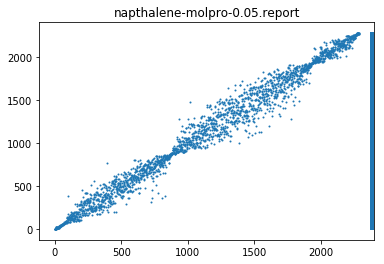

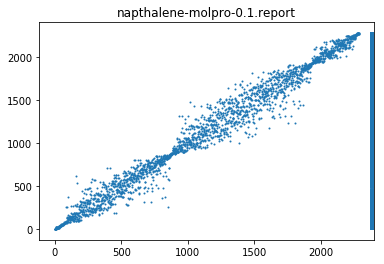

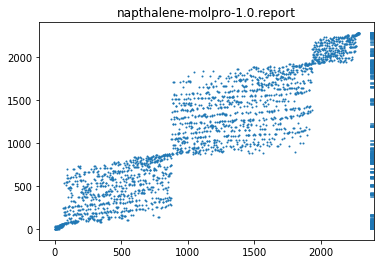

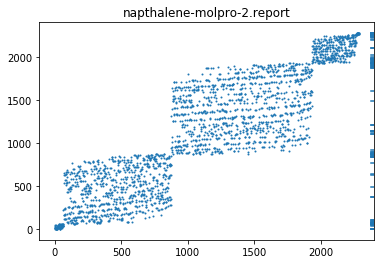

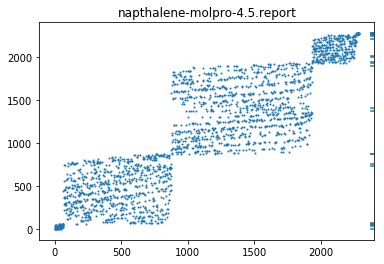

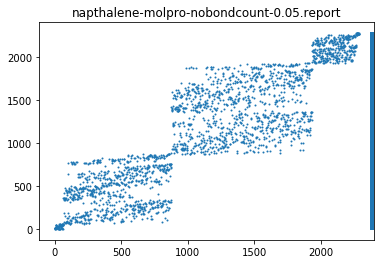

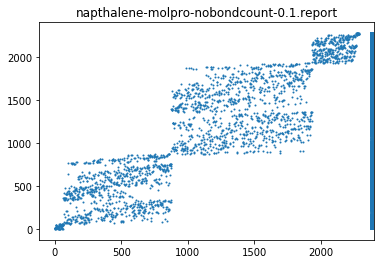

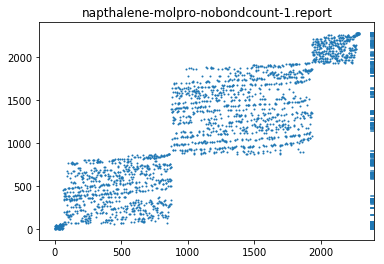

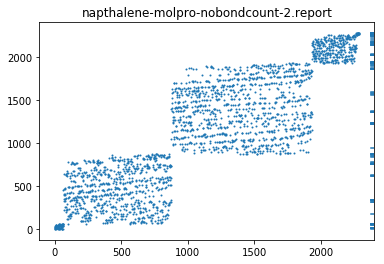

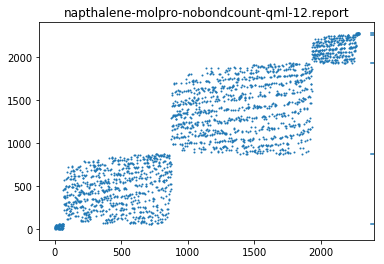

In [14]:
for i in glob.glob('*.report'):
    try:
        visualise_report(i, df)
    except:
        continue
    plt.title(i)
    plt.show()

In [17]:
def bond_count(label):
    bonds = {'BH': 0, 'CH': 0, 'HN': 0, 'BB': 0, 'BC': 0, 'BN': 0, 'CC': 0, 'CN': 0, 'NN': 0, }
    infile = [(4, 14), (3, 13), (3, 9), (2, 3), (4, 9), (4, 5), (5, 15), (2, 12), (8, 9), (1, 2), (5, 6), (1, 11), (0, 1), (6, 16), (6, 7), (7, 8), (0, 8), (7, 17), (0, 10)]
    for letter in label[:-2]:
        k = ''.join(sorted([letter, "H"]))
        bonds[k] += 1
    
    for a,b in infile:
        if a > 9 or b > 9:
            continue
        k = ''.join(sorted([label[_] for _ in (a, b)]))
        bonds[k] += 1
    return bonds

In [117]:
def ac_bond(df):
    A = np.zeros((len(df), 10))
    b = np.zeros((len(df)))
    #bondorder = sorted(bond_count(df.label.values[0].replace('5', 'B').replace('6', 'C').replace('7', 'N')).keys())
    bondorder = ['BB', 'BC', 'BH', 'BN', 'CC', 'CH', 'CN', 'HN', 'NN']
    print (bondorder)
    for idx, row in df.iterrows():
        counts = bond_count(row.label.replace('5', 'B').replace('6', 'C').replace('7', 'N'))
        A[idx] = [counts[_] for _ in bondorder] + [row.nbn]
        b[idx] = row.energy
    return A, b, np.linalg.lstsq(A, b)[0]

['BB', 'BC', 'BH', 'BN', 'CC', 'CH', 'CN', 'HN', 'NN']


/home/guido/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # This is added back by InteractiveShellApp.init_path()


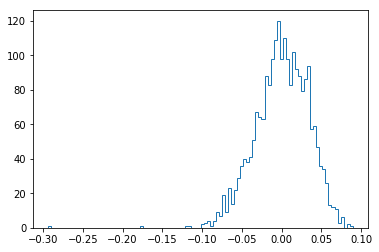

[-11.78452671 -15.1670447  -19.32057736 -11.89810962 -18.50208339
 -22.65337577 -15.16215434 -19.33173    -11.78139556 -23.3182617 ]


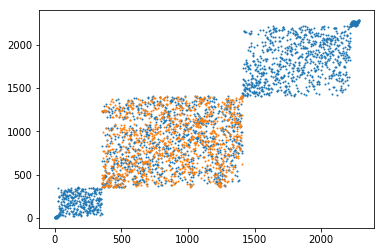

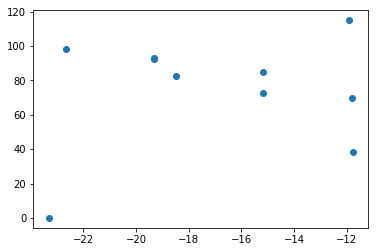

In [143]:
def test():
    s = df.query('nbn != 0').reset_index()
    A, b, coeff = ac_bond(s)
    residuals = np.dot(A, coeff) -b
    #plt.scatter(range(len(residuals)), residuals, s=10)
    plt.hist(residuals, bins=100, histtype='step')
    plt.show()
    plt.scatter(np.argsort(np.dot(A, coeff)), np.argsort(b), s=1)
    print (coeff)
    expval = [293/4.184, 356./4.184, 389/4.184, 115, 346./4.184, 411/4.184, 305./4.184, 386/4.184, 160./4.184, 0]
    
    offset = 0
    for idx, row in  s.groupby('nbn').count().reset_index().iterrows():
        if row.nbn != 3:
            offset += row.label
            continue
        bcorder = np.argsort(-np.dot(A[offset:offset + row.label], expval))
        expected = np.argsort(b[offset:offset + row.label])
        plt.scatter(bcorder + offset, expected+offset, s=1)
        offset += row.label
    
    plt.show()
    plt.scatter(coeff, expval)
test()

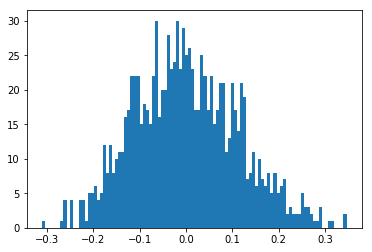

In [73]:
s = df.query("nbn == 3")
_ =plt.hist(s.energy.values - s.energy.values.mean(), bins=100)

In [164]:
def bond_energy(label):
    bondorder = ['BB', 'BC', 'BH', 'BN', 'CC', 'CH', 'CN', 'HN', 'NN']
    counts = bond_count(label) #.replace('5', 'B').replace('6', 'C').replace('7', 'N')
    a = np.array([counts[_] for _ in bondorder])
    b = [293/4.184, 356./4.184, 389/4.184, 115, 346./4.184, 411/4.184, 305./4.184, 386/4.184, 160./4.184]
    #b = [-11.78452671, -15.1670447,  -19.32057736, -11.89810962, -18.50208339, -22.65337577 ,-15.16215434, -19.33173 ,   -11.78139556]
    return -np.dot(a, b)
#bond_energy('5757757575')

In [194]:
labels = read_report('napthalene-molpro-0.01.report')[0][:66]
lenergies = [bond_energy(_) for _ in labels]
labels = np.array(labels)[np.argsort(lenergies)]
energies = []
enn = []
for label in labels:
    nolabel = label.replace('B', '5').replace('C', '6').replace('N', '7')
    energies.append(df.query("label == @nolabel").energy.values[0])
    enn.append(df.query("label == @nolabel").nn.values[0])

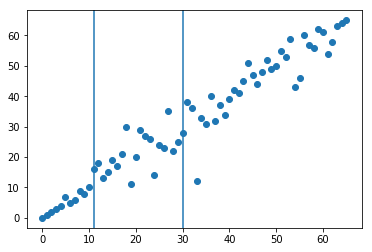

In [244]:
plt.scatter(range(len(energies)), np.argsort(energies))
plt.axvline(11)
plt.axvline(30)

In [501]:
tmp = []
for fn in glob.glob('scanning/*'):
    label = fn.split('/')[1]
    param, method = label.split('-')
    try:
        with open(fn) as fh:
            ncomponents = [_.strip().split()[0] for _ in fh.readlines() if 'components' in _][0]
    except:
        continue
    original, improved = rerank(fn)
    tmp.append({'method': method, 'param': float(param), 'components': int(ncomponents), 'original': original, 'improved': improved})
tmp = pd.DataFrame(tmp)

groups 710
groups 706
groups 790
groups 623
groups 561
groups 501
groups 390
groups 783
groups 330
groups 271
groups 209
groups 160
groups 123
groups 783
groups 102
groups 71
groups 54
groups 39
groups 29
groups 1
groups 1
groups 1
groups 1
groups 721
groups 23
groups 23
groups 672
groups 17
groups 606
groups 15
groups 521
groups 14
groups 351
groups 14
groups 1
groups 1
groups 303
groups 14
groups 271
groups 13
groups 239
groups 11
groups 211
groups 10
groups 160
groups 9
groups 1
groups 1
groups 1
groups 90
groups 8
groups 39
groups 6
groups 20
groups 6
groups 6
groups 5
groups 6
groups 5
groups 1
groups 1
groups 6
groups 5
groups 6
groups 4
groups 6
groups 3
groups 6
groups 2
groups 6
groups 2
groups 1
groups 1
groups 1
groups 6
groups 1
groups 1
groups 1
groups 1
groups 1
groups 1
groups 6
groups 1
groups 1
groups 1
groups 1
groups 1


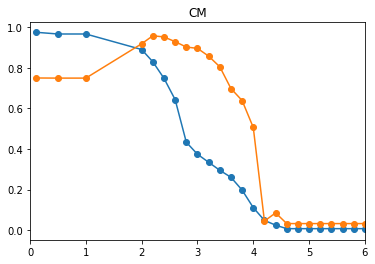

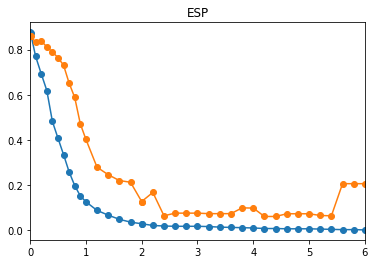

In [503]:
for name, group in tmp.sort_values('param').groupby('method'):
    
    plt.plot(group.param, group.components.values/810, 'o-')
    plt.plot(group.param, group.improved, 'o-')
    
    plt.title(name)
    plt.xlim(0, 6)
    plt.show()

groups 623


(0.9132971181573605, 0.8319707961868673)

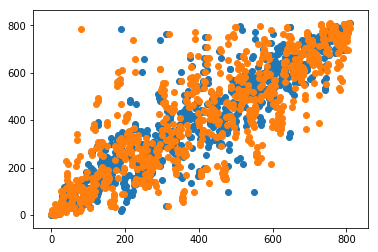

In [517]:
def build_mat(group, bondorder):
    A = []
    for label in group:
        counts = bond_count(label)
        A.append([counts[_] for _ in bondorder])
    return np.array(A)

def solve_group(group, bondorder):
    A = build_mat(group, bondorder)
    if 0 in np.sum(A, axis=0):
        return None
    coeffs = np.linalg.lstsq(A, np.zeros(len(A))+100, rcond=None)[0]
    return coeffs

def rate_coefficients(coeffs, A, b):
    return sts.spearmanr(np.dot(A, coeffs), b).correlation

def rerank(report):
    # read groups
    bondorder = ['BB', 'BC', 'BH', 'BN', 'CC', 'CH', 'CN', 'HN', 'NN']
    ranking, groupsizes = read_report(report)
    A = build_mat(ranking, bondorder)
    b = []
    bnn = []
    for label in ranking:
        nolabel = label.replace('B', '5').replace('C', '6').replace('N', '7')
        b.append(df.query("label == @nolabel").energy.values[0])# - df.query("label == @nolabel").nn.values[0] )
        bnn.append(df.query("label == @nolabel").nn.values[0] )
    b = np.array(b)
    bnn = np.array(bnn)
    
    # split groups
    groups = []
    modranking = ranking[:]
    for chunk in groupsizes:
        groups.append(modranking[:chunk])
        modranking = modranking[chunk:]
    groups.append(modranking)
    print ("groups", len(groups))
        
    # solve each group
    results = []
    sizes = []
    coefficients = []
    for group in groups:
        if len(group) <2:
            continue
        this = solve_group(group, bondorder)
        if this is not None and (this>0).all():
            sizes.append(len(group))
            results.append(rate_coefficients(this, A, b))
            
            # only insert if no duplicate
            for e in coefficients:
                delta = np.linalg.norm(e-this)
                if delta < 1e-10:
                    break
            else:
                coefficients.append(this)
    coeff = -np.array(coefficients).mean(axis=0)
    
    # rerank
    group_energies = []
    for group in groups:
        Atmp = build_mat(group, bondorder)
        group_energies.append(np.dot(Atmp, coeff).mean())
    
    reranked = []
    for idx in np.argsort(group_energies):
        reranked += groups[idx]
    
    # mix in NN ranking to ensure stability for few groups with valid regressions
    rankNN = np.argsort(bnn)
    newrank = np.array([reranked.index(_) for _ in ranking])
    N = len(coefficients)
    mixed = np.argsort(rankNN/N + newrank * N)
    reranked = [ranking[_] for _ in mixed]    
    
    # calculate original and improved score
    expected = list(df.query("nbn==4").sort_values("energy").label.str.replace('5', 'B').str.replace('6', 'C').str.replace('7', 'N').values)
    actual = [expected.index(_) for _ in ranking]
    xs = list(range(len(actual)))
    original = sts.spearmanr(xs, actual).correlation
    plt.scatter(xs, actual)
    
    actual = [expected.index(_) for _ in reranked]
    xs = list(range(len(actual)))
    improved = sts.spearmanr(xs, actual).correlation
    
    plt.scatter(xs, actual)
    
    return original, improved
rerank('scanning/0.1-ESP')

SpearmanrResult(correlation=0.897326041848948, pvalue=3.121319001624838e-289)

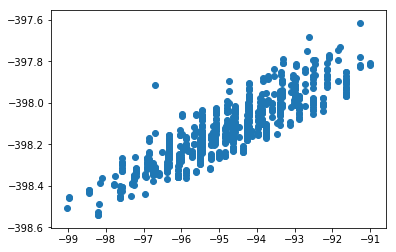

In [388]:
prod = np.dot(q[-2], -np.array(q[2]).mean(axis=0))
plt.scatter(prod, q[-1])
sts.spearmanr(prod, q[-1])

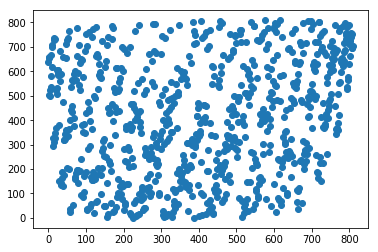

In [492]:
s = df.query("nbn == 4").sort_values("energy")
plt.scatter(list(range(len(s))), np.argsort(s.nn.values))